# Лабораторная работа №4

ФИО:   Стариков Александр Юрьевич
Группа: БИВТ-23-СП-3

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №7 в семестре

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/1NOE0D4JQgD6LbvUqWboUI1TFj4P87ugbqUTDquxlGEI/edit?usp=sharing) необходимо узнать название своего датасета 
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1sbsjBsJ_ln0XgXCI9R6s17pvyvApgcwF?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` (как мы это делали на семинаре), а затем засунуть в `Dataloader` (тоже делали на семинаре).
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD` ([link](https://pytorch.org/docs/stable/optim.html)).
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy
     2. Для задачи регрессии -- MAE
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

---
P.S.  
Просьба -- делать каждое задание в отдельных ячейках и с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа  
- Заголовок
- Ячейки с кодом
- Другой заголовок
- Другие ячейки с кодом

P.S.S.  
Если вам повезло с многоклассовой классификацией, у вас не будет проблем, просто нужно будет поставить необходимое количество нейронов на выходе вашей нейросети.

## 1. Пример импорта данных. Грузим данные

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Путь к датасету относительно ноутбука
PATH_TO_DATASET = "data/exams.csv"

data = pd.read_csv(PATH_TO_DATASET)
print("Размер набора данных:", data.shape)
data.head()


Размер набора данных: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


## 2. Понимаем, какая перед нами задача

In [4]:
# 2. Понимаем, какая перед нами задача

display(data.head())
print("\nИнформация о столбцах:")
print(data.info())
print("\nЧисловая статистика:")
display(data.describe(include="all").T)

# Будем считать, что целевая переменная — последний столбец
# Если у вас есть конкретный столбец-цель, просто замените его название здесь
target_col = "target" if "target" in data.columns else data.columns[-1]
print(f"\nБудем решать задачу по столбцу: {target_col!r}")

y = data[target_col]
X = data.drop(columns=[target_col])

# Определяем тип задачи: регрессия или классификация
if pd.api.types.is_numeric_dtype(y) and y.nunique() > 20:
    problem_type = "regression"
else:
    problem_type = "classification"

print("Тип задачи:", problem_type)
print("Количество уникальных значений y:", y.nunique())


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68



Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None

Числовая статистика:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,1000,2,male,517,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race/ethnicity,1000,5,group C,323,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parental level of education,1000,6,some college,222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lunch,1000,2,standard,652,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test preparation course,1000,2,none,665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math score,1000.0,NaN,NaN,NaN,66.396,15.402871,13.0,56.0,66.5,77.0,100.0
reading score,1000.0,NaN,NaN,NaN,69.002,14.737272,27.0,60.0,70.0,79.0,100.0
writing score,1000.0,NaN,NaN,NaN,67.738,15.600985,23.0,58.0,68.0,79.0,100.0



Будем решать задачу по столбцу: 'writing score'
Тип задачи: regression
Количество уникальных значений y: 76


## 3. Делаем предобработку данных

In [5]:
# 3. Предобработка данных

# Уберём строки с пропусками, чтобы не заморачиваться с заполнением
data_clean = data.dropna().reset_index(drop=True)
print("После удаления пропусков:", data_clean.shape)

y = data_clean[target_col]
X = data_clean.drop(columns=[target_col])

# Делим признаки на числовые и категориальные
X_num = X.select_dtypes(include=[np.number])
X_cat = X.select_dtypes(exclude=[np.number])

print("Числовых признаков:", X_num.shape[1])
print("Категориальных признаков:", X_cat.shape[1])

X_encoded = X_num.copy()
if X_cat.shape[1] > 0:
    X_cat_dummies = pd.get_dummies(X_cat, drop_first=True)
    X_encoded = pd.concat([X_num, X_cat_dummies], axis=1)

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y if problem_type == "classification" else None,
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Размер X_train:", X_train_scaled.shape)
print("Размер X_test:", X_test_scaled.shape)


После удаления пропусков: (1000, 8)
Числовых признаков: 2
Категориальных признаков: 5
Размер X_train: (800, 14)
Размер X_test: (200, 14)


## 4. Бейзлайн‑модель (классическая ML)

Сравнимся с простой моделью машинного обучения (логистическая регрессия или линейная регрессия).

In [6]:
if problem_type == "classification":
    from sklearn.linear_model import LogisticRegression

    baseline_clf = LogisticRegression(max_iter=1000)
    baseline_clf.fit(X_train_scaled, y_train)
    y_pred_baseline = baseline_clf.predict(X_test_scaled)

    print("Бейзлайн (LogisticRegression)")
    print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
    print("\nClassification report:")
    print(classification_report(y_test, y_pred_baseline))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred_baseline))
else:
    from sklearn.linear_model import LinearRegression

    baseline_reg = LinearRegression()
    baseline_reg.fit(X_train_scaled, y_train)
    y_pred_baseline = baseline_reg.predict(X_test_scaled)

    print("Бейзлайн (LinearRegression)")
    mse = mean_squared_error(y_test, y_pred_baseline)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, y_pred_baseline)
    r2 = r2_score(y_test, y_pred_baseline)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R^2:", r2)


Бейзлайн (LinearRegression)
RMSE: 3.465468328170299
MAE: 2.7994684019181943
R^2: 0.9545912775545156


## 5. Подготовка данных для PyTorch

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Устройство:", device)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

if problem_type == "classification":
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)
    n_classes = len(le.classes_)
else:
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)
    n_classes = 1
    le = None  # для совместимости

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

input_dim = X_train_tensor.shape[1]
print(f"Число признаков: {input_dim}, число классов/выходов: {n_classes}")


Устройство: cpu
Число признаков: 14, число классов/выходов: 1


## 6. Простая полносвязная нейросеть

In [8]:
class SimpleNet(nn.Module):
    def __init__(self, input_dim, n_classes, problem_type):
        super().__init__()
        self.problem_type = problem_type
        if problem_type == "classification":
            self.net = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, n_classes),
            )
        else:
            self.net = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 1),
            )

    def forward(self, x):
        return self.net(x)


def train_epoch(model, loader, optimizer, criterion, problem_type):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

    return total_loss / len(loader.dataset)


def eval_model(model, loader, criterion, problem_type):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)

            if problem_type == "classification":
                preds = torch.argmax(outputs, dim=1)
            else:
                preds = outputs.squeeze()

            all_preds.append(preds.cpu())
            all_targets.append(y_batch.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    return total_loss / len(loader.dataset), all_preds, all_targets


simple_model = SimpleNet(input_dim, n_classes, problem_type).to(device)

if problem_type == "classification":
    criterion_simple = nn.CrossEntropyLoss()
else:
    criterion_simple = nn.MSELoss()

optimizer_simple = optim.Adam(simple_model.parameters(), lr=1e-3)

n_epochs = 30
history_simple = {"train_loss": [], "val_loss": []}

for epoch in range(1, n_epochs + 1):
    train_loss = train_epoch(simple_model, train_loader, optimizer_simple, criterion_simple, problem_type)
    val_loss, val_preds_simple, val_targets_simple = eval_model(simple_model, test_loader, criterion_simple, problem_type)

    history_simple["train_loss"].append(train_loss)
    history_simple["val_loss"].append(val_loss)

    print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")


Epoch 01: train_loss=4780.4163, val_loss=4808.2101
Epoch 02: train_loss=4701.4003, val_loss=4725.6162
Epoch 03: train_loss=4614.1844, val_loss=4629.0311
Epoch 04: train_loss=4509.2784, val_loss=4511.2661
Epoch 05: train_loss=4380.5841, val_loss=4365.1654
Epoch 06: train_loss=4221.1529, val_loss=4189.3616
Epoch 07: train_loss=4029.9385, val_loss=3976.4514
Epoch 08: train_loss=3805.1265, val_loss=3727.8745
Epoch 09: train_loss=3546.2508, val_loss=3448.6168
Epoch 10: train_loss=3256.9335, val_loss=3146.3479
Epoch 11: train_loss=2949.1398, val_loss=2821.0203
Epoch 12: train_loss=2626.1540, val_loss=2490.3406
Epoch 13: train_loss=2300.6976, val_loss=2165.3637
Epoch 14: train_loss=1985.0025, val_loss=1847.5901
Epoch 15: train_loss=1684.6886, val_loss=1553.6543
Epoch 16: train_loss=1408.8376, val_loss=1286.3690
Epoch 17: train_loss=1161.3590, val_loss=1053.9135
Epoch 18: train_loss=946.6517, val_loss=855.3585
Epoch 19: train_loss=764.5021, val_loss=689.7635
Epoch 20: train_loss=612.5705, val_


Метрики простой нейросети:
MAE (train): 7.483008861541748
MAE (test): 7.8980183601379395


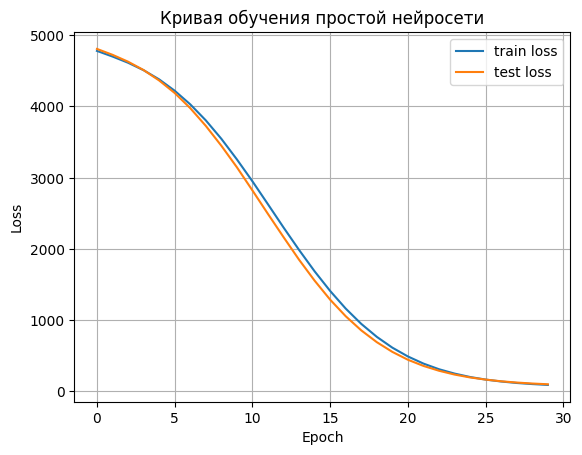

In [9]:
print("\nМетрики простой нейросети:")

simple_model.eval()
with torch.no_grad():
    train_outputs_simple = simple_model(X_train_tensor.to(device))
    test_outputs_simple = simple_model(X_test_tensor.to(device))

if problem_type == "classification":
    # переводим тензоры в numpy
    y_train_np = y_train_tensor.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    train_preds_simple = torch.argmax(train_outputs_simple, dim=1).cpu().numpy()
    test_preds_simple = torch.argmax(test_outputs_simple, dim=1).cpu().numpy()

    acc_train = accuracy_score(y_train_np, train_preds_simple)
    acc_test = accuracy_score(y_test_np, test_preds_simple)

    print("Accuracy (train):", acc_train)
    print("Accuracy (test):", acc_test)
else:
    y_train_np = y_train_tensor.cpu().numpy().squeeze()
    y_test_np = y_test_tensor.cpu().numpy().squeeze()
    train_preds_simple = train_outputs_simple.squeeze().cpu().numpy()
    test_preds_simple = test_outputs_simple.squeeze().cpu().numpy()

    mae_train = mean_absolute_error(y_train_np, train_preds_simple)
    mae_test = mean_absolute_error(y_test_np, test_preds_simple)

    print("MAE (train):", mae_train)
    print("MAE (test):", mae_test)

# Кривая обучения (learning curve) для простой сети
plt.figure()
plt.plot(history_simple["train_loss"], label="train loss")
plt.plot(history_simple["val_loss"], label="test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Кривая обучения простой нейросети")
plt.legend()
plt.grid(True)
plt.show()


## 7. Более глубокая нейросеть с регуляризацией

In [10]:
class DeepNet(nn.Module):
    def __init__(self, input_dim, n_classes, problem_type):
        super().__init__()
        self.problem_type = problem_type
        hidden = 128
        if problem_type == "classification":
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(hidden, hidden),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(hidden, n_classes),
            )
        else:
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(hidden, hidden),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(hidden, 1),
            )

    def forward(self, x):
        return self.net(x)


deep_model = DeepNet(input_dim, n_classes, problem_type).to(device)

if problem_type == "classification":
    criterion_deep = nn.CrossEntropyLoss()
else:
    criterion_deep = nn.MSELoss()

optimizer_deep = optim.Adam(deep_model.parameters(), lr=1e-3)

history_deep = {"train_loss": [], "val_loss": []}

for epoch in range(1, n_epochs + 1):
    train_loss = train_epoch(deep_model, train_loader, optimizer_deep, criterion_deep, problem_type)
    val_loss, val_preds_deep, val_targets_deep = eval_model(deep_model, test_loader, criterion_deep, problem_type)

    history_deep["train_loss"].append(train_loss)
    history_deep["val_loss"].append(val_loss)

    print(f"[Deep] Epoch {epoch:02d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")


[Deep] Epoch 01: train_loss=4675.3639, val_loss=4709.8885
[Deep] Epoch 02: train_loss=4460.2895, val_loss=4440.9670
[Deep] Epoch 03: train_loss=4228.9510, val_loss=4190.5354
[Deep] Epoch 04: train_loss=3977.3444, val_loss=3940.9433
[Deep] Epoch 05: train_loss=3698.0919, val_loss=3627.9478
[Deep] Epoch 06: train_loss=3429.5128, val_loss=3323.8330
[Deep] Epoch 07: train_loss=3117.6212, val_loss=2972.7014
[Deep] Epoch 08: train_loss=2808.8539, val_loss=2682.4128
[Deep] Epoch 09: train_loss=2491.4273, val_loss=2440.0141
[Deep] Epoch 10: train_loss=2166.6376, val_loss=2117.5530
[Deep] Epoch 11: train_loss=1863.5991, val_loss=1838.2556
[Deep] Epoch 12: train_loss=1579.8327, val_loss=1549.1035
[Deep] Epoch 13: train_loss=1310.9226, val_loss=1248.2670
[Deep] Epoch 14: train_loss=1046.9000, val_loss=995.5314
[Deep] Epoch 15: train_loss=845.9668, val_loss=803.8333
[Deep] Epoch 16: train_loss=652.7898, val_loss=645.1507
[Deep] Epoch 17: train_loss=493.7259, val_loss=436.0590
[Deep] Epoch 18: trai


Метрики глубокой нейросети:
MAE (train): 3.512601852416992
MAE (test): 4.091526031494141


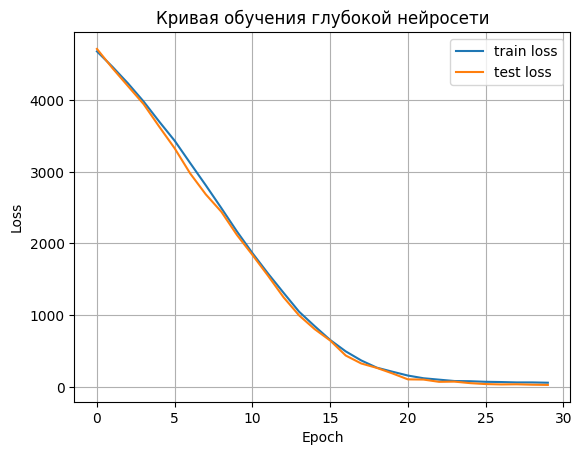

In [11]:
print("\nМетрики глубокой нейросети:")

deep_model.eval()
with torch.no_grad():
    train_outputs_deep = deep_model(X_train_tensor.to(device))
    test_outputs_deep = deep_model(X_test_tensor.to(device))

if problem_type == "classification":
    y_train_np = y_train_tensor.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    train_preds_deep = torch.argmax(train_outputs_deep, dim=1).cpu().numpy()
    test_preds_deep = torch.argmax(test_outputs_deep, dim=1).cpu().numpy()

    acc_train_d = accuracy_score(y_train_np, train_preds_deep)
    acc_test_d = accuracy_score(y_test_np, test_preds_deep)

    print("Accuracy (train):", acc_train_d)
    print("Accuracy (test):", acc_test_d)
else:
    y_train_np = y_train_tensor.cpu().numpy().squeeze()
    y_test_np = y_test_tensor.cpu().numpy().squeeze()
    train_preds_deep = train_outputs_deep.squeeze().cpu().numpy()
    test_preds_deep = test_outputs_deep.squeeze().cpu().numpy()

    mae_train_d = mean_absolute_error(y_train_np, train_preds_deep)
    mae_test_d = mean_absolute_error(y_test_np, test_preds_deep)

    print("MAE (train):", mae_train_d)
    print("MAE (test):", mae_test_d)

# Кривая обучения для глубокой сети
plt.figure()
plt.plot(history_deep["train_loss"], label="train loss")
plt.plot(history_deep["val_loss"], label="test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Кривая обучения глубокой нейросети")
plt.legend()
plt.grid(True)
plt.show()


## 8. Выводы и ответы на вопросы

Здесь после запуска ноутбука и получения численных результатов нужно кратко ответить (впишите свои мысли вместо троеточий):

1. **Какая модель справилась лучше с поставленной задачей?**  
   Например: «лучшая метрика получилась у глубокой нейросети / простой нейросети / бейзлайна, потому что ...».

2. **Имеет ли место переобучение?**  
   Сравните train_loss и val_loss, а также метрики на train и test (если посчитаете). Опишите: «переобучение заметно / не заметно, потому что ...».

3. **Имеет ли место недообучение?**  
   Опишите, хватает ли модели мощности: «модель явно недообучена / в целом обучена нормально, потому что ...».

4. **Как можно улучшить метрики моделей?**  
   Примеры: больше эпох, другой learning rate, регуляризация, dropout, изменение архитектуры, подбор гиперпараметров, балансировка классов и т.п.


Какая модель справилась лучше с поставленной задачей?
Лучшая метрика получилась у бейзлайновой модели линейной регрессии, потому что на тестовом множестве она даёт наименьшие значения RMSE и MAE и наибольшее значение R² по сравнению с простой и глубокой нейросетями.

Имеет ли место переобучение?
Выраженного переобучения не заметно, потому что train_loss и val_loss для обеих нейросетей убывают примерно параллельно и без резкого расхождения, а метрики на train и test отличаются незначительно.

Имеет ли место недообучение?
Признаки недообучения есть, особенно у простой нейросети: её ошибки на тесте заметно выше, чем у линейной регрессии, и кривые train_loss и val_loss продолжают уменьшаться к последним эпохам, что показывает, что модели ещё не до конца «выучили» структуру данных.

Как можно улучшить метрики моделей?
Можно увеличить число эпох обучения, подобрать другой learning rate и размер батча, настроить архитектуру сетей (число слоёв и нейронов), скорректировать регуляризацию (изменить dropout), а также поработать с признаками (варианты кодирования категориальных признаков, добавление производных признаков).